In [1]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict

In [2]:
lsize=14
titlesize=16
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'),'whis':[5, 95],'flierprops':dict(marker='.',markersize=2)}
bar_kwargs = {'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
bar_unintended_kwargs = {'color':'#ff9e9e', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = 1.5

In [3]:
#templatedf = pd.read_csv('20211208_templatedf_focused_with_features.csv')
templatedf = pd.read_csv('20220719_templatedf_focused_with_features.csv')
protospacerendposition = -30
templatedf['basebeforeproto'] = templatedf['Disease_Block'].apply(lambda x: str(Seq(x[protospacerendposition-0:protospacerendposition+1]).reverse_complement()))

#backup_tempdf = pd.read_csv('20211114_templatedffull_focused_editing.csv')

# clamp values of averageedited/indel/unedited to 0 to 100 to be consistent with prediction models
templatedf['averageedited'] = templatedf['averageedited'].apply(lambda x: 0 if x < 0 else (100 if x > 100 else x))
templatedf['averageindel'] = templatedf['averageindel'].apply(lambda x: 0 if x < 0 else (100 if x > 100 else x))
templatedf['averageunedited'] = templatedf.apply(lambda x: 100-x.averageindel-x.averageedited ,axis=1)

templatedf['templatedfindex'] = templatedf.index

templatedf = templatedf.set_index('Unnamed: 0')

#original_templatedf = pd.reads_csv('../01_Library_Sequence_Analysis/

In [4]:
crispressopath = '../01_Library_Sequence_Analysis/03_Read_Analysis/01_CRISPResso_Unintended_Analysis/CRISPResso_Output/'
ctrlunintenddf = pd.read_csv(crispressopath+'20220818_CRISPResso_long_summary_CRISPRessoBatch_on_20220812_06-NM-C0_crispresso_batch_amasdef.csv')
PErep1unintenddf = pd.read_csv(crispressopath+'20220818_CRISPResso_long_summary_CRISPRessoBatch_on_20220812_01-NM-PE1_crispresso_batch_amasdef.csv')
PErep2unintenddf = pd.read_csv(crispressopath+'20220818_CRISPResso_long_summary_CRISPRessoBatch_on_20220812_02-NM-PE2_crispresso_batch_amasdef.csv')
PErep3unintenddf = pd.read_csv(crispressopath+'20220818_CRISPResso_long_summary_CRISPRessoBatch_on_20220812_03-NM-PE3_crispresso_batch_amasdef.csv')

dataframedict = {'ctrlunintenddf':ctrlunintenddf, 'PErep1unintenddf':PErep1unintenddf, 'PErep2unintenddf':PErep2unintenddf, 'PErep3unintenddf':PErep3unintenddf}


C:\Users\nimath\Anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
for dataframe in dataframedict:
    dataframedict[dataframe] = dataframedict[dataframe][dataframedict[dataframe]['Unnamed: 0'] != 'Mean']  # remove Mean row from end of dataframe
    dataframedict[dataframe]['variantnr'] = dataframedict[dataframe]['variantnr'].astype('int32')
    dataframedict[dataframe] = dataframedict[dataframe].sort_values('variantnr')
    dataframedict[dataframe] = dataframedict[dataframe][dataframedict[dataframe]['variantnr'] < 119742] 
    dataframedict[dataframe] = dataframedict[dataframe].set_index('variantnr')
    dataframedict[dataframe]['modified_total_percentage'] = (dataframedict[dataframe]['readsalignedtotal'] - dataframedict[dataframe]['readsaligned_Unmodified_reference'] - dataframedict[dataframe]['readsaligned_Unmodified_hdr'])/dataframedict[dataframe]['readsalignedtotal']*100
    dataframedict[dataframe]['readsaligned_Unmodified_hdr_percentage'] = dataframedict[dataframe]['readsaligned_Unmodified_hdr']/dataframedict[dataframe]['readsalignedtotal']*100
    #dataframedict[dataframe].apply(lambda x: x.readsaligned_Unmodified_hdr/x.readsalignedtotal*100 ,axis=1)

    #else:
    #    dataframedict[dataframe]['modified_total_percentage'] = (dataframedict[dataframe]['readsaligned_modified_reference'] + dataframedict[dataframe]['readsaligned_modified_hdr'])

C:\Users\nimath\AppData\Local\Temp/ipykernel_16248/285851714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframedict[dataframe]['variantnr'] = dataframedict[dataframe]['variantnr'].astype('int32')
C:\Users\nimath\AppData\Local\Temp/ipykernel_16248/285851714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframedict[dataframe]['variantnr'] = dataframedict[dataframe]['variantnr'].astype('int32')
C:\Users\nimath\AppData\Local\Temp/ipykernel_16248/285851714.py:3: SettingWithCopyWarning: 
A valu

In [6]:
PErep1unintenddf.sort_values('variantnr')

,Unnamed: 0,variantnr,readsalignedtotal,readsaligned_total_reference,readsaligned_total_hdr,readsaligned_Unmodified_reference,readsaligned_Unmodified_hdr,readsaligned_modified_reference,readsaligned_modified_hdr,readsaligned_insertions_reference,...,referenceflapsubstitution_5,referenceflapsubstitution_6,referenceflapsubstitution_7,referenceflapmutation_1,referenceflapmutation_2,referenceflapmutation_3,referenceflapmutation_4,referenceflapmutation_5,referenceflapmutation_6,referenceflapmutation_7
4748,5215,0.0,1911.000000,1910.000000,1.000000,1867.00000,0.000000,43.000000,1.000000,0.000000,...,0.157068,0.157068,0.052356,0.000000,0.052356,0.261780,1.047120,0.157068,0.157068,0.052356
73818,81091,1.0,1611.000000,1611.000000,0.000000,1576.00000,0.000000,35.000000,0.000000,0.000000,...,0.062073,0.372439,0.186220,0.124146,0.372439,0.248293,0.372439,0.062073,0.372439,0.186220
42585,46708,2.0,759.000000,759.000000,0.000000,713.00000,0.000000,46.000000,0.000000,0.000000,...,0.000000,0.131752,0.131752,0.000000,0.131752,0.131752,0.131752,0.000000,0.131752,0.131752
50279,55188,3.0,1231.000000,1217.000000,14.000000,1165.00000,0.000000,52.000000,14.000000,0.000000,...,0.082169,0.328677,0.493016,0.164339,0.000000,0.739523,0.246508,0.082169,0.328677,0.493016
67263,73878,8.0,642.000000,211.000000,427.000000,192.00000,355.000000,19.000000,72.000000,5.000000,...,1.895735,2.369668,1.421801,1.421801,0.947867,0.000000,2.369668,1.895735,2.369668,1.421801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18538,20312,119740.0,2052.000000,186.000000,1857.000000,174.00000,1708.000000,12.000000,149.000000,0.000000,...,0.000000,1.612903,1.612903,1.612903,0.000000,1.612903,1.612903,0.000000,1.612903,1.612903
18233,19978,119741.0,508.000000,131.000000,373.000000,112.00000,333.000000,19.000000,40.000000,1.000000,...,5.343511,6.870229,0.000000,0.000000,8.396947,1.526718,0.000000,5.343511,6.870229,0.000000
59829,65688,119743.0,630.000000,40.000000,583.000000,31.00000,368.000000,9.000000,215.000000,0.000000,...,2.500000,2.500000,0.000000,0.000000,2.500000,2.500000,5.000000,2.500000,5.000000,2.500000
90110,98974,119745.0,542.000000,58.000000,483.000000,56.00000,456.000000,2.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
dataframedict['ctrlunintenddf'] = dataframedict['ctrlunintenddf'][dataframedict['ctrlunintenddf']['modified_total_percentage'] < 20]
dataframedict['ctrlunintenddf'] = dataframedict['ctrlunintenddf'][dataframedict['ctrlunintenddf']['readsaligned_Unmodified_hdr_percentage'] < 5]

In [8]:
path = '../01_library_Sequence_Analysis/03_Read_Analysis/'
oldtemplatedf = pd.read_csv(path+'20210701_templatefiltered.csv')

In [9]:
colslist = ['nickinsertion_1', 'nickinsertion_2', 'nickinsertion_3', 'nickinsertion_4', 'nickdeletion_1', 'nickdeletion_2', 'nickdeletion_3', 'nickdeletion_4',
 'nicksubstitution_1', 'nicksubstitution_2', 'nicksubstitution_3', 'nicksubstitution_4', 'nickmutation_1', 'nickmutation_2', 'nickmutation_3', 'nickmutation_4',
 'flapinsertion_1', 'flapinsertion_2', 'flapinsertion_3', 'flapinsertion_4','flapinsertion_5', 'flapinsertion_6', 'flapinsertion_7', 'flapdeletion_1', 'flapdeletion_2', 'flapdeletion_3', 'flapdeletion_4','flapdeletion_5', 'flapdeletion_6', 'flapdeletion_7', 'flapsubstitution_1',
 'flapsubstitution_2', 'flapsubstitution_3', 'flapsubstitution_4','flapsubstitution_5', 'flapsubstitution_6', 'flapsubstitution_7', 'flapmutation_1', 'flapmutation_2', 'flapmutation_3', 'flapmutation_4','flapmutation_5', 'flapmutation_6', 'flapmutation_7', 'pbsinsertionaverage', 'pbsdeletionaverage', 'pbssubstitutionaverage', 'pbsmutationaverage', 'rttinsertionaverage', 'rttdeletionaverage', 'rttsubstitutionaverage', 
             'rttmutationaverage']

In [10]:
summarydf = templatedf.copy()
cols = ['templatedfindex','Name',
 'Gene',
 'Phenotype',
 'Disease_Block',
 'PBSlength',
 'RToverhanglength',
 'RTlength',
 'ReferenceAllele',
 'AlternateAllele',
 'Correction_Type',
 'Correction_Length',
 'DesignNr_per_variant',
 'Editing_Position',
 'Target_Strand','averageedited','averageindel','averageunedited']
summarydf = summarydf[cols]
for dataframe in dataframedict:
    #print(dataframe)
    for col in colslist:
        #print(col)
        if dataframe == 'ctrlunintenddf':  # for control-dataframe don't calculate hdr/reference since here we don't distiungish yet (very low "hdr" counts would highly skew results otherwise)
            #dataframedict[dataframe][col+'_percentage'] = (dataframedict[dataframe][col]/dataframedict[dataframe]['readsalignedtotal'])*100            
            summarydf[dataframe+'_'+col+'_percentage'] = dataframedict[dataframe][col]
        else:
            for amptype in ['hdr','reference']:
                #dataframedict[dataframe][amptype+col+'_percentage'] = (dataframedict[dataframe][amptype+col]/dataframedict[dataframe]['readsalignedtotal'])*100
                summarydf[dataframe+'_'+amptype+col+'_percentage'] = dataframedict[dataframe][amptype+col]
        
                
    summarydf[dataframe+'_'+'readsalignedtotal'] = dataframedict[dataframe]['readsalignedtotal']
    

In [11]:
readsalignedtotallist = []
for dataframe in dataframedict:
    readsalignedtotallist.append(dataframe+'_'+'readsalignedtotal')
summarydf = summarydf.dropna(subset=readsalignedtotallist)

for dataframe in dataframedict:
    summarydf[dataframe+'_'+'edited_percentage'] = dataframedict[dataframe]['readsaligned_Unmodified_hdr_percentage']
    summarydf[dataframe+'_'+'modified_total_percentage'] = dataframedict[dataframe]['modified_total_percentage']
    
    if dataframe == 'ctrlunintenddf':  # only make controladjusted columns for rep1-rep3 (not for control itself)
        continue
    else:
        for col in colslist:
            for amptype in ['hdr','reference']: # ctrlunintenddf_nickinsertion_1_percentage
                summarydf[dataframe+'_'+amptype+col+'_percentage_ctrladjusted'] = (summarydf[dataframe+'_'+amptype+col+'_percentage'] - summarydf['ctrlunintenddf'+'_'+col+'_percentage'])/(100-summarydf['ctrlunintenddf'+'_'+col+'_percentage'])*100
                
        summarydf[dataframe+'_'+'modified_total_percentage_ctrladjusted'] = (summarydf[dataframe+'_'+'modified_total_percentage'] - summarydf['ctrlunintenddf'+'_'+'modified_total_percentage'])/(100-summarydf['ctrlunintenddf'+'_'+'modified_total_percentage'])*100
        summarydf[dataframe+'_'+'edited_percentage_ctrladjusted'] = (summarydf[dataframe+'_'+'edited_percentage'] - summarydf['ctrlunintenddf'+'_'+'edited_percentage'])/(100-summarydf['ctrlunintenddf'+'_'+'edited_percentage'])*100
        
for col in colslist:
    for amptype in ['hdr','reference']:
        summarydf['average'+'_'+amptype+col+'_percentage_ctrladjusted'] = summarydf[['PErep1unintenddf'+'_'+amptype+col+'_percentage_ctrladjusted', 'PErep2unintenddf'+'_'+amptype+col+'_percentage_ctrladjusted', 'PErep3unintenddf'+'_'+amptype+col+'_percentage_ctrladjusted']].mean(axis=1)
        
summarydf['average_edited'+'_percentage_ctrladjusted'] = summarydf[['PErep1unintenddf'+'_'+'edited_percentage_ctrladjusted', 'PErep2unintenddf'+'_'+'edited_percentage_ctrladjusted', 'PErep3unintenddf'+'_'+'edited_percentage_ctrladjusted']].mean(axis=1)
summarydf['clipped_'+'average_edited_percentage_ctrladjusted'] = summarydf['average_edited_percentage_ctrladjusted'].apply(lambda x: 0 if x < 0 else (100 if x > 100 else x))

summarydf['average_modified_total'+'_percentage_ctrladjusted'] = summarydf[['PErep1unintenddf'+'_'+'modified_total_percentage_ctrladjusted', 'PErep2unintenddf'+'_'+'modified_total_percentage_ctrladjusted', 'PErep3unintenddf'+'_'+'modified_total_percentage_ctrladjusted']].mean(axis=1)
summarydf['clipped_'+'average_modified_total_percentage_ctrladjusted'] = summarydf['average_modified_total_percentage_ctrladjusted'].apply(lambda x: 0 if x < 0 else (100 if x > 100 else x))

In [12]:
mutationcolslist = [x for x in colslist if 'mutation' in x]
for col in mutationcolslist:
    print(col)
    for index, row in summarydf.iterrows():
        if (row['average'+'_'+'hdr'+col+'_percentage_ctrladjusted'] > 0) or (row['average'+'_'+'hdr'+col+'_percentage_ctrladjusted'] < 0):
            summarydf.at[index, 'average'+'_'+col+'_percentage_ctrladjusted'] = row['average'+'_'+'hdr'+col+'_percentage_ctrladjusted']*(row['clipped_average_edited_percentage_ctrladjusted']/100)+row['average'+'_'+'reference'+col+'_percentage_ctrladjusted']*((100-row['clipped_average_edited_percentage_ctrladjusted'])/100)
        else:  # if there is no HDR alignment, use 0 for percentage unintended editing here (otherwise it will give None for the sum)
            summarydf.at[index, 'average'+'_'+col+'_percentage_ctrladjusted'] = row['average'+'_'+'reference'+col+'_percentage_ctrladjusted']*((100-row['clipped_average_edited_percentage_ctrladjusted'])/100)

nickmutation_1
nickmutation_2
nickmutation_3
nickmutation_4
flapmutation_1
flapmutation_2
flapmutation_3
flapmutation_4
flapmutation_5
flapmutation_6
flapmutation_7
pbsmutationaverage
rttmutationaverage


In [13]:
collist = ['templatedfindex',
 'Name',
 'Gene',
 'Phenotype',
 'Disease_Block',
 'PBSlength',
 'RToverhanglength',
 'RTlength',
 'ReferenceAllele',
 'AlternateAllele',
 'Correction_Type',
 'Correction_Length',
 'DesignNr_per_variant',
 'Editing_Position',
 'Target_Strand',
 'averageedited',
 'averageindel',
 'averageunedited',
 'average_hdrnickinsertion_1_percentage_ctrladjusted',
 'average_referencenickinsertion_1_percentage_ctrladjusted',
 'average_hdrnickinsertion_2_percentage_ctrladjusted',
 'average_referencenickinsertion_2_percentage_ctrladjusted',
 'average_hdrnickinsertion_3_percentage_ctrladjusted',
 'average_referencenickinsertion_3_percentage_ctrladjusted',
 'average_hdrnickinsertion_4_percentage_ctrladjusted',
 'average_referencenickinsertion_4_percentage_ctrladjusted',
 'average_hdrnickdeletion_1_percentage_ctrladjusted',
 'average_referencenickdeletion_1_percentage_ctrladjusted',
 'average_hdrnickdeletion_2_percentage_ctrladjusted',
 'average_referencenickdeletion_2_percentage_ctrladjusted',
 'average_hdrnickdeletion_3_percentage_ctrladjusted',
 'average_referencenickdeletion_3_percentage_ctrladjusted',
 'average_hdrnickdeletion_4_percentage_ctrladjusted',
 'average_referencenickdeletion_4_percentage_ctrladjusted',
 'average_hdrnicksubstitution_1_percentage_ctrladjusted',
 'average_referencenicksubstitution_1_percentage_ctrladjusted',
 'average_hdrnicksubstitution_2_percentage_ctrladjusted',
 'average_referencenicksubstitution_2_percentage_ctrladjusted',
 'average_hdrnicksubstitution_3_percentage_ctrladjusted',
 'average_referencenicksubstitution_3_percentage_ctrladjusted',
 'average_hdrnicksubstitution_4_percentage_ctrladjusted',
 'average_referencenicksubstitution_4_percentage_ctrladjusted',
 'average_hdrnickmutation_1_percentage_ctrladjusted',
 'average_referencenickmutation_1_percentage_ctrladjusted',
 'average_hdrnickmutation_2_percentage_ctrladjusted',
 'average_referencenickmutation_2_percentage_ctrladjusted',
 'average_hdrnickmutation_3_percentage_ctrladjusted',
 'average_referencenickmutation_3_percentage_ctrladjusted',
 'average_hdrnickmutation_4_percentage_ctrladjusted',
 'average_referencenickmutation_4_percentage_ctrladjusted',
 'average_hdrflapinsertion_1_percentage_ctrladjusted',
 'average_referenceflapinsertion_1_percentage_ctrladjusted',
 'average_hdrflapinsertion_2_percentage_ctrladjusted',
 'average_referenceflapinsertion_2_percentage_ctrladjusted',
 'average_hdrflapinsertion_3_percentage_ctrladjusted',
 'average_referenceflapinsertion_3_percentage_ctrladjusted',
 'average_hdrflapinsertion_4_percentage_ctrladjusted',
 'average_referenceflapinsertion_4_percentage_ctrladjusted',
 'average_hdrflapinsertion_5_percentage_ctrladjusted',
 'average_referenceflapinsertion_5_percentage_ctrladjusted',
 'average_hdrflapinsertion_6_percentage_ctrladjusted',
 'average_referenceflapinsertion_6_percentage_ctrladjusted',
 'average_hdrflapinsertion_7_percentage_ctrladjusted',
 'average_referenceflapinsertion_7_percentage_ctrladjusted',
 'average_hdrflapdeletion_1_percentage_ctrladjusted',
 'average_referenceflapdeletion_1_percentage_ctrladjusted',
 'average_hdrflapdeletion_2_percentage_ctrladjusted',
 'average_referenceflapdeletion_2_percentage_ctrladjusted',
 'average_hdrflapdeletion_3_percentage_ctrladjusted',
 'average_referenceflapdeletion_3_percentage_ctrladjusted',
 'average_hdrflapdeletion_4_percentage_ctrladjusted',
 'average_referenceflapdeletion_4_percentage_ctrladjusted',
 'average_hdrflapdeletion_5_percentage_ctrladjusted',
 'average_referenceflapdeletion_5_percentage_ctrladjusted',
 'average_hdrflapdeletion_6_percentage_ctrladjusted',
 'average_referenceflapdeletion_6_percentage_ctrladjusted',
 'average_hdrflapdeletion_7_percentage_ctrladjusted',
 'average_referenceflapdeletion_7_percentage_ctrladjusted',
 'average_hdrflapsubstitution_1_percentage_ctrladjusted',
 'average_referenceflapsubstitution_1_percentage_ctrladjusted',
 'average_hdrflapsubstitution_2_percentage_ctrladjusted',
 'average_referenceflapsubstitution_2_percentage_ctrladjusted',
 'average_hdrflapsubstitution_3_percentage_ctrladjusted',
 'average_referenceflapsubstitution_3_percentage_ctrladjusted',
 'average_hdrflapsubstitution_4_percentage_ctrladjusted',
 'average_referenceflapsubstitution_4_percentage_ctrladjusted',
 'average_hdrflapsubstitution_5_percentage_ctrladjusted',
 'average_referenceflapsubstitution_5_percentage_ctrladjusted',
 'average_hdrflapsubstitution_6_percentage_ctrladjusted',
 'average_referenceflapsubstitution_6_percentage_ctrladjusted',
 'average_hdrflapsubstitution_7_percentage_ctrladjusted',
 'average_referenceflapsubstitution_7_percentage_ctrladjusted',
 'average_hdrflapmutation_1_percentage_ctrladjusted',
 'average_referenceflapmutation_1_percentage_ctrladjusted',
 'average_hdrflapmutation_2_percentage_ctrladjusted',
 'average_referenceflapmutation_2_percentage_ctrladjusted',
 'average_hdrflapmutation_3_percentage_ctrladjusted',
 'average_referenceflapmutation_3_percentage_ctrladjusted',
 'average_hdrflapmutation_4_percentage_ctrladjusted',
 'average_referenceflapmutation_4_percentage_ctrladjusted',
 'average_hdrflapmutation_5_percentage_ctrladjusted',
 'average_referenceflapmutation_5_percentage_ctrladjusted',
 'average_hdrflapmutation_6_percentage_ctrladjusted',
 'average_referenceflapmutation_6_percentage_ctrladjusted',
 'average_hdrflapmutation_7_percentage_ctrladjusted',
 'average_referenceflapmutation_7_percentage_ctrladjusted',
 'average_hdrpbsinsertionaverage_percentage_ctrladjusted',
 'average_referencepbsinsertionaverage_percentage_ctrladjusted',
 'average_hdrpbsdeletionaverage_percentage_ctrladjusted',
 'average_referencepbsdeletionaverage_percentage_ctrladjusted',
 'average_hdrpbssubstitutionaverage_percentage_ctrladjusted',
 'average_referencepbssubstitutionaverage_percentage_ctrladjusted',
 'average_hdrpbsmutationaverage_percentage_ctrladjusted',
 'average_referencepbsmutationaverage_percentage_ctrladjusted',
 'average_hdrrttinsertionaverage_percentage_ctrladjusted',
 'average_referencerttinsertionaverage_percentage_ctrladjusted',
 'average_hdrrttdeletionaverage_percentage_ctrladjusted',
 'average_referencerttdeletionaverage_percentage_ctrladjusted',
 'average_hdrrttsubstitutionaverage_percentage_ctrladjusted',
 'average_referencerttsubstitutionaverage_percentage_ctrladjusted',
 'average_hdrrttmutationaverage_percentage_ctrladjusted',
 'average_referencerttmutationaverage_percentage_ctrladjusted',
 'average_edited_percentage_ctrladjusted',
 'clipped_average_edited_percentage_ctrladjusted',
 'average_modified_total_percentage_ctrladjusted',
 'clipped_average_modified_total_percentage_ctrladjusted',
 'average_nickmutation_1_percentage_ctrladjusted',
 'average_nickmutation_2_percentage_ctrladjusted',
 'average_nickmutation_3_percentage_ctrladjusted',
 'average_nickmutation_4_percentage_ctrladjusted',
 'average_flapmutation_1_percentage_ctrladjusted',
 'average_flapmutation_2_percentage_ctrladjusted',
 'average_flapmutation_3_percentage_ctrladjusted',
 'average_flapmutation_4_percentage_ctrladjusted',
 'average_flapmutation_5_percentage_ctrladjusted',
 'average_flapmutation_6_percentage_ctrladjusted',
 'average_flapmutation_7_percentage_ctrladjusted',
 'average_pbsmutationaverage_percentage_ctrladjusted',
 'average_rttmutationaverage_percentage_ctrladjusted']

shortsummarydf = summarydf[collist].copy()

In [14]:
shortsummarydf.to_csv('20220814_UnintendedEditing_CRISPResso_shortsummarydf.csv')

In [15]:
shortsummarydf = pd.read_csv('20220814_UnintendedEditing_CRISPResso_shortsummarydf.csv')

In [16]:
shortsummarydf['clipped_'+'average_modified_total_percentage_ctrladjusted'].describe()

count    88911.000000
mean        11.604072
std         12.895833
min          0.000000
25%          2.748587
50%          7.429181
75%         15.915051
max         96.978981
Name: clipped_average_modified_total_percentage_ctrladjusted, dtype: float64

In [17]:
shortsummarydf[['averageindel','clipped_average_modified_total_percentage_ctrladjusted']].corr()

,averageindel,clipped_average_modified_total_percentage_ctrladjusted
averageindel,1.000000,0.996435
clipped_average_modified_total_percentage_ctrladjusted,0.996435,1.000000


Text(80, 10, 'R = 0.99\nr = 1.0')

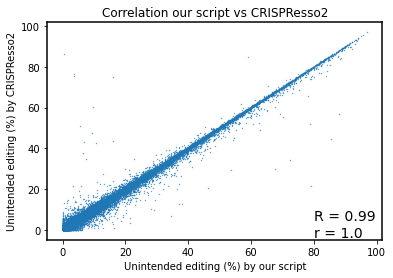

In [18]:
R = stats.spearmanr(shortsummarydf['averageindel'],shortsummarydf['clipped_average_modified_total_percentage_ctrladjusted'])[0]
r = stats.pearsonr(shortsummarydf['averageindel'],shortsummarydf['clipped_average_modified_total_percentage_ctrladjusted'])[0]


plt.scatter(shortsummarydf['averageindel'],shortsummarydf['clipped_average_modified_total_percentage_ctrladjusted'],s=0.1)
plt.title('Correlation our script vs CRISPResso2')
plt.xlabel('Unintended editing (%) by our script')
plt.ylabel('Unintended editing (%) by CRISPResso2')
plt.text(80,10, 'R = '+str(round(R, 2))+'\nr = '+str(round(r, 2)), fontsize=14,
        verticalalignment='top')

In [19]:
shortsummarydf[['averageedited','clipped_average_edited_percentage_ctrladjusted']].corr()

,averageedited,clipped_average_edited_percentage_ctrladjusted
averageedited,1.000000,0.999636
clipped_average_edited_percentage_ctrladjusted,0.999636,1.000000


Text(80, 10, 'R = 1.0\nr = 1.0')

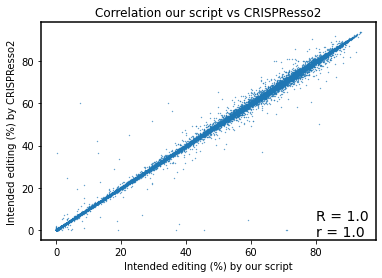

In [20]:
R = stats.spearmanr(shortsummarydf['averageedited'],shortsummarydf['clipped_average_edited_percentage_ctrladjusted'])[0]
r = stats.pearsonr(shortsummarydf['averageedited'],shortsummarydf['clipped_average_edited_percentage_ctrladjusted'])[0]


plt.scatter(shortsummarydf['averageedited'],shortsummarydf['clipped_average_edited_percentage_ctrladjusted'],s=0.1)
plt.title('Correlation our script vs CRISPResso2')
plt.xlabel('Intended editing (%) by our script')
plt.ylabel('Intended editing (%) by CRISPResso2')
plt.text(80,10, 'R = '+str(round(R, 2))+'\nr = '+str(round(r, 2)), fontsize=14,
        verticalalignment='top')

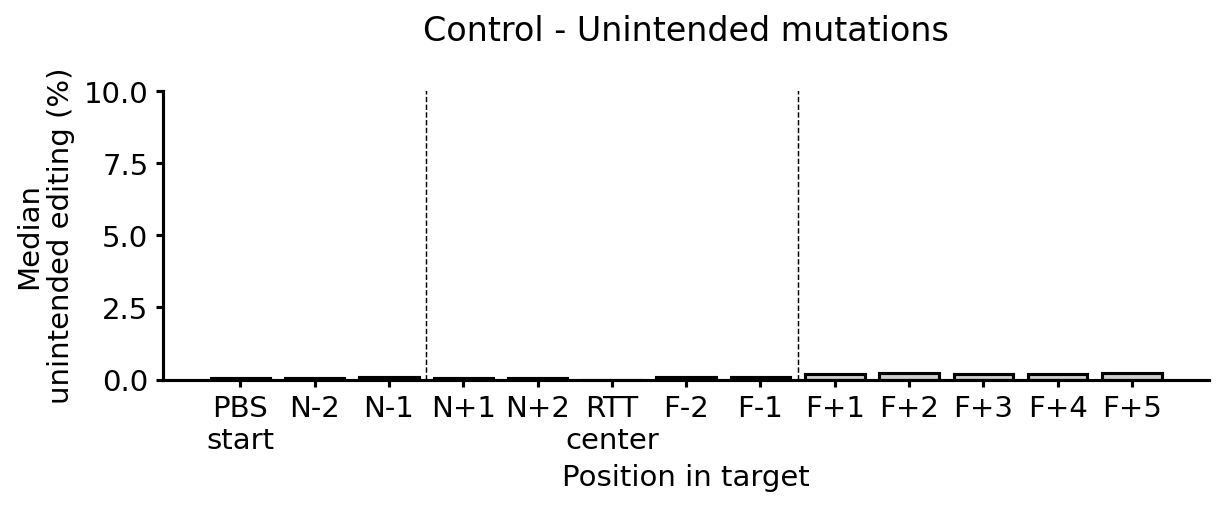

In [24]:
mpl.rc_file_defaults()
edittype = 'mutation'
dataframe = dataframedict['ctrlunintenddf'].copy()

collist = ['pbs'+edittype+'average','nick'+edittype+'_1','nick'+edittype+'_2','nick'+edittype+'_3','nick'+edittype+'_4','rtt'+edittype+'average','flap'+edittype+'_1','flap'+edittype+'_2','flap'+edittype+'_3','flap'+edittype+'_4','flap'+edittype+'_5','flap'+edittype+'_6','flap'+edittype+'_7']

mutationdict = {}
for col in collist:
    mutationdict[col] = dataframe[col].median()

mutationlist = []
for col in collist:
    mutationlist.append(mutationdict[col])

labels = ['PBS\nstart','N-2', 'N-1', 'N+1', 'N+2', 'RTT\ncenter', 'F-2', 'F-1', 'F+1', 'F+2','F+3', 'F+4','F+5']
colorlist = ['#C5DEFF','#C5DEFF','#C5DEFF','#8bc997','#8bc997','#8bc997','#8bc997','#8bc997','#cfcfcf','#cfcfcf','#cfcfcf','#cfcfcf','#cfcfcf']


fig1, ax1 = plt.subplots(figsize = (9, 2.5),dpi=150)
ax1.set_title('Control - Unintended mutations\n', fontsize=titlesize)
ax1.bar(labels, mutationlist, color=colorlist, **bar_kwargs)
ax1.set_ylabel('Median\nunintended editing (%)', fontsize=lsize)
ax1.set_xlabel('Position in target', fontsize=lsize)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(0.0,10)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)
ax1.axvline(2.5,0,10, color ='black', linewidth=0.7, linestyle='--')
ax1.axvline(7.5,0,10, color ='black', linewidth=0.7, linestyle='--')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup1c_Unintended_Editing\\'
plt.savefig(figurepath+'unintended_editing_position_control.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

88911


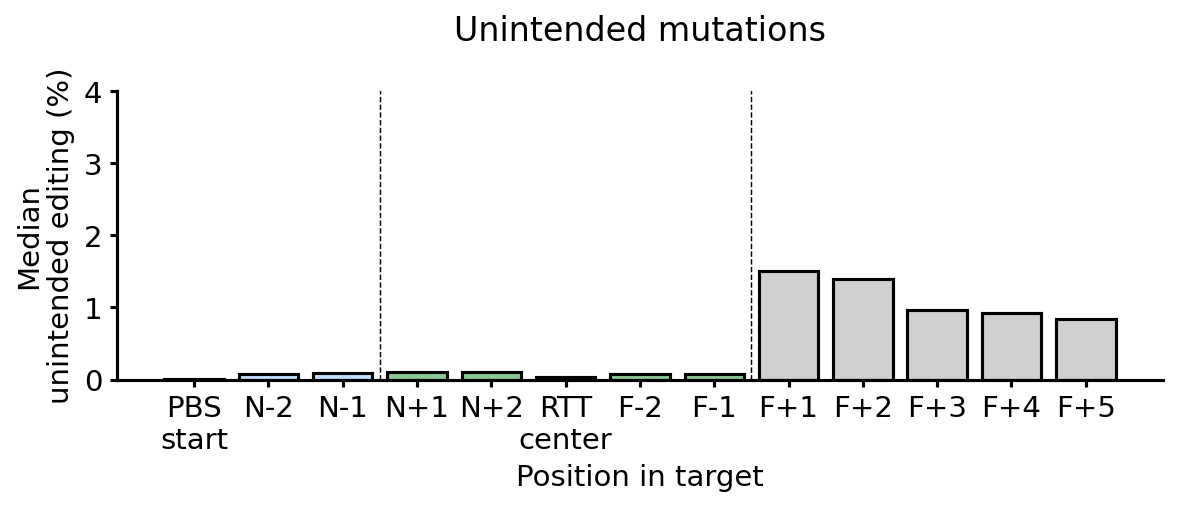

In [26]:
mpl.rc_file_defaults()
edittype = 'mutation'

collist = list(shortsummarydf.columns)
collist = [x for x in collist if ('percentage_ctrladjusted' in x) and not ('unintenddf' in x)]
mutationcollist = [x for x in collist if (edittype in x) and not (('hdr' in x) or ('reference' in x))]


mutationdict = {}
for col in mutationcollist:
    mutationdict[col] = shortsummarydf[col].median()
    
mutationorder = ['average_pbs'+edittype+'average_percentage_ctrladjusted','average_nick'+edittype+'_1_percentage_ctrladjusted',
 'average_nick'+edittype+'_2_percentage_ctrladjusted',
 'average_nick'+edittype+'_3_percentage_ctrladjusted',
 'average_nick'+edittype+'_4_percentage_ctrladjusted', 'average_rtt'+edittype+'average_percentage_ctrladjusted',
 'average_flap'+edittype+'_1_percentage_ctrladjusted',
 'average_flap'+edittype+'_2_percentage_ctrladjusted',
 'average_flap'+edittype+'_3_percentage_ctrladjusted',
 'average_flap'+edittype+'_4_percentage_ctrladjusted','average_flap'+edittype+'_5_percentage_ctrladjusted',
 'average_flap'+edittype+'_6_percentage_ctrladjusted',
 'average_flap'+edittype+'_7_percentage_ctrladjusted']


mutationlist = []
for col in mutationorder:
    mutationlist.append(mutationdict[col])
    
mutationlist
labels = ['PBS\nstart','N-2', 'N-1', 'N+1', 'N+2', 'RTT\ncenter', 'F-2', 'F-1', 'F+1', 'F+2','F+3', 'F+4','F+5']

fig1, ax1 = plt.subplots(figsize = (9, 2.5),dpi=150)
ax1.set_title('Unintended mutations\n', fontsize=titlesize)
colorlist = ['#C5DEFF','#C5DEFF','#C5DEFF','#8bc997','#8bc997','#8bc997','#8bc997','#8bc997','#cfcfcf','#cfcfcf','#cfcfcf','#cfcfcf','#cfcfcf']
ax1.bar(labels, mutationlist, color=colorlist,**bar_kwargs)
ax1.set_ylabel('Median\nunintended editing (%)', fontsize=lsize)
ax1.set_xlabel('Position in target', fontsize=lsize)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(0.0,4)
#ax1.set_yticks(list(np.arange(0.1,1.0,0.2)))
ax1.tick_params(axis='x', labelsize= lsize, width=1.5)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)
ax1.axvline(2.5,0,10, color ='black', linewidth=0.7, linestyle='--')
ax1.axvline(7.5,0,10, color ='black', linewidth=0.7, linestyle='--')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup1c_Unintended_Editing\\'
plt.savefig(figurepath+'unintended_editing_positions.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

print(len(shortsummarydf))

In [69]:
shortsummarydf.clipped_average_edited_percentage_ctrladjusted.mean()

41.463424655309424

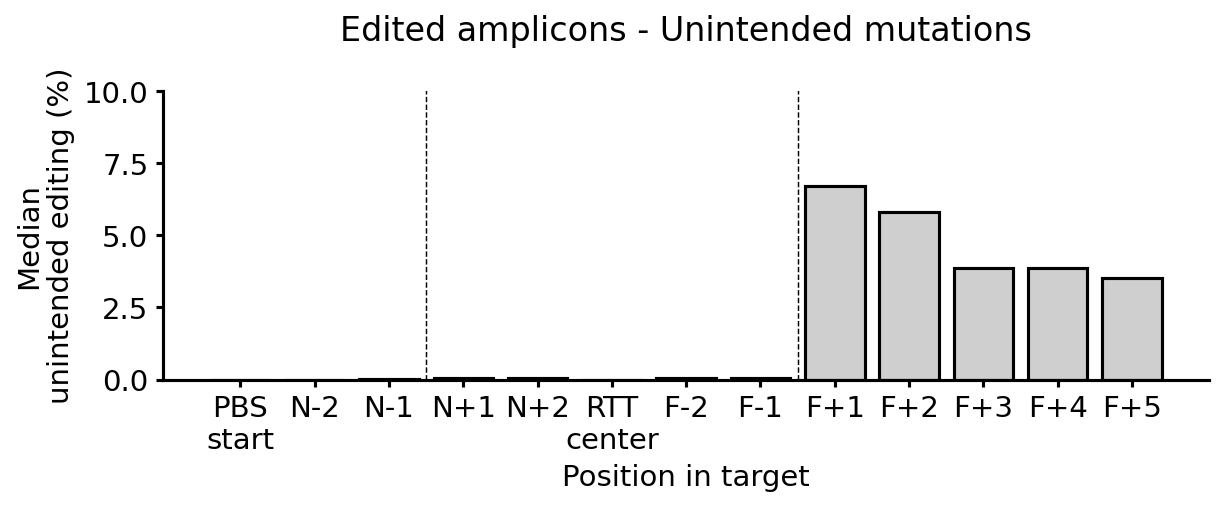

In [27]:
mpl.rc_file_defaults()
edittype = 'mutation'

collist = list(shortsummarydf.columns)
collist = [x for x in collist if ('percentage_ctrladjusted' in x) and not ('unintenddf' in x)]
hdrmutationcollist = [x for x in collist if ('hdr' in x) and (edittype in x)]
referencemutationcollist = [x for x in collist if ('reference' in x) and (edittype in x)]


hdrmutationdict = {}
for col in hdrmutationcollist:
    hdrmutationdict[col] = shortsummarydf[col].median()
    
hdrmutationorder = ['average_hdrpbs'+edittype+'average_percentage_ctrladjusted','average_hdrnick'+edittype+'_1_percentage_ctrladjusted',
 'average_hdrnick'+edittype+'_2_percentage_ctrladjusted',
 'average_hdrnick'+edittype+'_3_percentage_ctrladjusted',
 'average_hdrnick'+edittype+'_4_percentage_ctrladjusted', 'average_hdrrtt'+edittype+'average_percentage_ctrladjusted',
 'average_hdrflap'+edittype+'_1_percentage_ctrladjusted',
 'average_hdrflap'+edittype+'_2_percentage_ctrladjusted',
 'average_hdrflap'+edittype+'_3_percentage_ctrladjusted',
 'average_hdrflap'+edittype+'_4_percentage_ctrladjusted','average_hdrflap'+edittype+'_5_percentage_ctrladjusted',
 'average_hdrflap'+edittype+'_6_percentage_ctrladjusted',
 'average_hdrflap'+edittype+'_7_percentage_ctrladjusted']


hdrmutationlist = []
for col in hdrmutationorder:
    hdrmutationlist.append(hdrmutationdict[col])
    
hdrmutationlist
labels = ['PBS\nstart','N-2', 'N-1', 'N+1', 'N+2', 'RTT\ncenter', 'F-2', 'F-1', 'F+1', 'F+2','F+3', 'F+4','F+5']

fig1, ax1 = plt.subplots(figsize = (9, 2.5),dpi=150)
ax1.set_title('Edited amplicons - Unintended mutations\n', fontsize=titlesize)
colorlist = ['#C5DEFF','#C5DEFF','#C5DEFF','#8bc997','#8bc997','#8bc997','#8bc997','#8bc997','#cfcfcf','#cfcfcf','#cfcfcf','#cfcfcf','#cfcfcf']
ax1.bar(labels, hdrmutationlist, color=colorlist, **bar_kwargs)
ax1.set_ylabel('Median\nunintended editing (%)', fontsize=lsize)
ax1.set_xlabel('Position in target', fontsize=lsize)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(0.0,10)
#ax1.set_yticks(list(np.arange(0.1,1.0,0.2)))
ax1.tick_params(axis='x', labelsize= lsize, width=1.5)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)
ax1.axvline(2.5,0,10, color ='black', linewidth=0.7, linestyle='--')
ax1.axvline(7.5,0,10, color ='black', linewidth=0.7, linestyle='--')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup1c_Unintended_Editing\\'
plt.savefig(figurepath+'unintended_editedamplicions_editing_positions.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

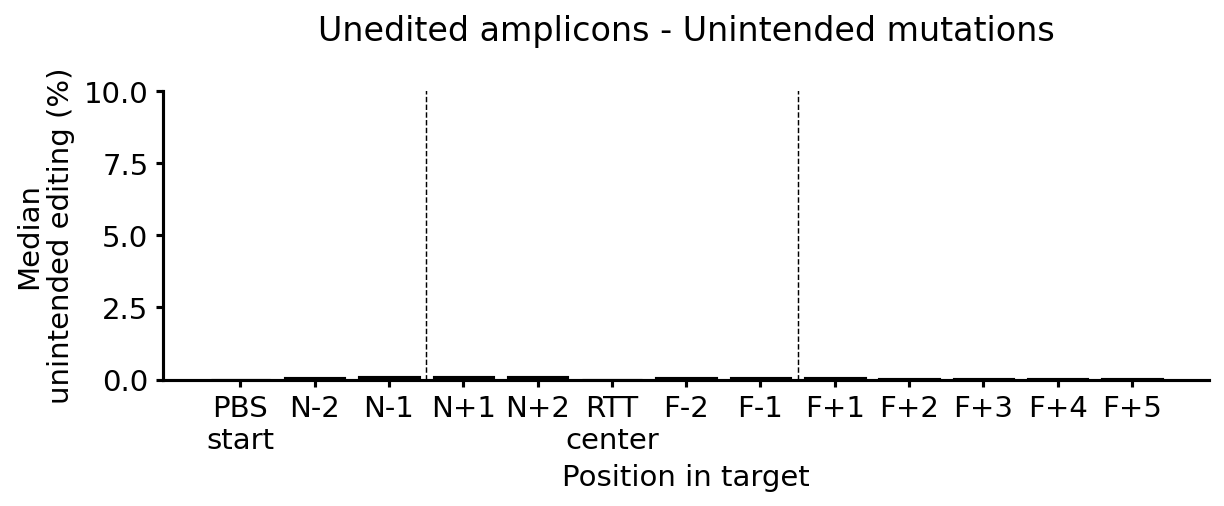

In [28]:
mpl.rc_file_defaults()
edittype = 'mutation'

collist = list(shortsummarydf.columns)
collist = [x for x in collist if ('percentage_ctrladjusted' in x) and not ('unintenddf' in x)]
hdrmutationcollist = [x for x in collist if ('hdr' in x) and (edittype in x)]
referencemutationcollist = [x for x in collist if ('reference' in x) and (edittype in x)]


referencemutationdict = {}
for col in referencemutationcollist:
    referencemutationdict[col] = shortsummarydf[col].median()

referencemutationorder = ['average_referencepbs'+edittype+'average_percentage_ctrladjusted','average_referencenick'+edittype+'_1_percentage_ctrladjusted',
 'average_referencenick'+edittype+'_2_percentage_ctrladjusted',
 'average_referencenick'+edittype+'_3_percentage_ctrladjusted',
 'average_referencenick'+edittype+'_4_percentage_ctrladjusted', 'average_referencertt'+edittype+'average_percentage_ctrladjusted',
 'average_referenceflap'+edittype+'_1_percentage_ctrladjusted',
 'average_referenceflap'+edittype+'_2_percentage_ctrladjusted',
 'average_referenceflap'+edittype+'_3_percentage_ctrladjusted',
 'average_referenceflap'+edittype+'_4_percentage_ctrladjusted','average_referenceflap'+edittype+'_5_percentage_ctrladjusted',
 'average_referenceflap'+edittype+'_6_percentage_ctrladjusted',
 'average_referenceflap'+edittype+'_7_percentage_ctrladjusted']
referencemutationdict

referencemutationlist = []
for col in referencemutationorder:
    referencemutationlist.append(referencemutationdict[col])
    
referencemutationlist

labels = ['PBS\nstart','N-2', 'N-1', 'N+1', 'N+2', 'RTT\ncenter', 'F-2', 'F-1', 'F+1', 'F+2','F+3', 'F+4','F+5']

fig1, ax1 = plt.subplots(figsize = (9, 2.5),dpi=150)
ax1.set_title('Unedited amplicons - Unintended mutations\n', fontsize=titlesize)
colorlist = ['#C5DEFF','#C5DEFF','#C5DEFF','#8bc997','#8bc997','#8bc997','#8bc997','#8bc997','#cfcfcf','#cfcfcf','#cfcfcf','#cfcfcf','#cfcfcf']
ax1.bar(labels, referencemutationlist, color=colorlist,**bar_kwargs)
ax1.set_ylabel('Median\nunintended editing (%)', fontsize=lsize)
ax1.set_xlabel('Position in target', fontsize=lsize)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(0.0,10)
#ax1.set_yticks(list(np.arange(0.1,1.0,0.2)))
ax1.tick_params(axis='x', labelsize= lsize, width=1.5)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)
ax1.axvline(2.5,0,10, color ='black', linewidth=0.7, linestyle='--')
ax1.axvline(7.5,0,10, color ='black', linewidth=0.7, linestyle='--')
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup1c_Unintended_Editing\\'
plt.savefig(figurepath+'unintended_uneditedamplicions_editing_positions.pdf', format='pdf',
        transparent=True,bbox_inches='tight')